# Compare atmospheres 

In [1]:
import numpy as np
import xarray as xr
import cmocean
from dask.distributed import Client, LocalCluster, wait
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy
import cartopy.crs as ccrs

In [2]:
plt.style.use('dark_background')

In [3]:
cluster = LocalCluster(n_workers=8, threads_per_worker=2, memory_limit='32GB',
                       silence_logs=50)
client = Client(address=cluster)
client

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39907 instead
  expected, actual


Client Scheduler: tcp://127.0.0.1:37449 Dashboard: http://127.0.0.1:39907/status,Cluster Workers: 8 Cores: 16 Memory: 238.42 GiB


In [4]:
## Read data

In [5]:
expnames = ['FOCI_GJK012','FOCI_BJK017','FOCI_BJK019']
times = [slice('1950-02-01','1959-12-31'),slice('1950-02-01','1952-12-31'),slice('1953-01-01','1959-12-31')]

In [6]:
_sfc_1m_all = []

for i, (exp,time) in enumerate( zip(expnames, times) ):
    
    # some files from 1959 are dead links, 
    # check gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/nemo/
    time_str = '195[0-9]????_*' 
    
    ddir = '/gxfs_work1/geomar/smomw352/esm-experiments/%s/outdata/oifs/' % (exp,)
    files = '%s/ECE3_1m_*_regular_sfc.nc' % (ddir,)
    print(files)
    _1m = xr.open_mfdataset(files,combine='nested', 
                             concat_dim="time_counter", 
                             data_vars='minimal', coords='minimal', compat='override',
                             parallel=True).rename({'time_counter':'time'}).sel(time=time)
    if exp == 'FOCI_BJK019': 
        _sfc_1m_all.append(_1m)#.drop('time_centered'))
    else:
        _sfc_1m_all.append(_1m)
    

/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK012/outdata/oifs//ECE3_1m_*_regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK017/outdata/oifs//ECE3_1m_*_regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/oifs//ECE3_1m_*_regular_sfc.nc


In [7]:
sfc_1m_all = [_sfc_1m_all[0], xr.concat(_sfc_1m_all[1:], dim='time')]

In [8]:
sfc_1m_all[0]

<xarray.Dataset>
Dimensions:               (lat: 96, lon: 192, time: 119, axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 -89.06 -87.19 -85.31 ... 87.19 89.06
  * lon                   (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
    time_centered         (time) datetime64[ns] dask.array<chunksize=(119,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1950-02-15 ... 1959-12-16T12:...
Dimensions without coordinates: axis_nbounds
Data variables: (12/44)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(119, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(119, 2), meta=np.ndarray>
    sz                    (time, lat, lon) float32 dask.array<chunksize=(119, 96, 192), meta=np.ndarray>
    sstk                  (time, lat, lon) float32 dask.array<chunksize=(119, 96, 192), meta=np.ndarray>
    ci                    (time, lat, lon) float32 dask.array<chunksize=(119, 96, 192), meta=np.ndarray>
    al                    (time, lat, lon) float32 dask.array<chunksize=(119, 96, 192), meta=np.ndarray>
    ...                    ...
    ttrc                  (time, lat, lon) float32 dask.array<chunksize=(119, 96, 192), meta=np.ndarray>
    ssrc                  (time, lat, lon) float32 dask.array<chunksize=(119, 96, 192), meta=np.ndarray>
    strc                  (time, lat, lon) float32 dask.array<chunksize=(119, 96, 192), meta=np.ndarray>
    tclw                  (time, lat, lon) float32 dask.array<chunksize=(119, 96, 192), meta=np.ndarray>
    tciw                  (time, lat, lon) float32 dask.array<chunksize=(119, 96, 192), meta=np.ndarray>
    tcwv                  (time, lat, lon) float32 dask.array<chunksize=(119, 96, 192), meta=np.ndarray>
Attributes:
    name:         ECE3_1m_19500101_regular_sfc
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2022-Oct-24 12:00:51 GMT
    uuid:         d2cce479-2caf-4e6e-b897-ed57f375a743

In [9]:
## Plot changes in atm vars

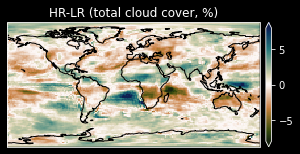

In [10]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,4),
                         subplot_kw={'projection':ccrs.PlateCarree()})

if 1:
    v = 'tcc'
    
    scale = 100
    vmax = 8
    z = sfc_1m_all[1][v].mean('time') - sfc_1m_all[0][v].mean('time')
    
    cbar_kwargs = {'label':'', 'pad':0.02}
    (z*scale).plot(ax=ax1, 
                   vmin=-vmax, vmax=vmax,
                   cbar_kwargs=cbar_kwargs,
                   cmap=cmocean.cm.tarn,
                   rasterized=True,
                   transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_aspect('auto')
    ax1.set_title('HR-LR (total cloud cover, %)')
    
fig1.tight_layout()
fig1.savefig('figures/tcc.pdf',format='pdf',dpi=150)

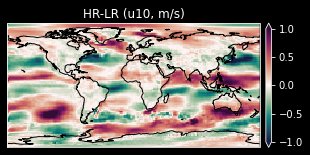

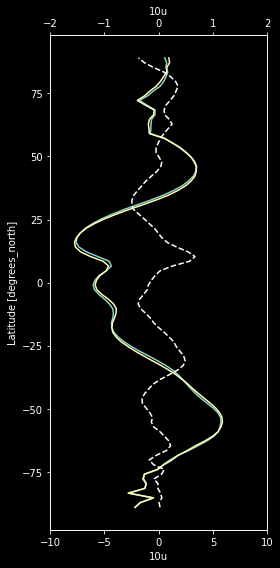

In [43]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,4),
                         subplot_kw={'projection':ccrs.PlateCarree()})

if 1:
    v = '10u'
    
    scale = 1
    vmax = 1
    z1 = sfc_1m_all[1][v].groupby('time.month').mean('time').mean('month') 
    z2 = sfc_1m_all[0][v].groupby('time.month').mean('time').mean('month')
    z = z1-z2
    
    cbar_kwargs = {'label':'', 'pad':0.02}
    (z*scale).plot(ax=ax1, 
                   vmin=-vmax, vmax=vmax,
                   cbar_kwargs=cbar_kwargs,
                   cmap=cmocean.cm.curl,
                   rasterized=True,
                   transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_aspect('auto')
    ax1.set_title('HR-LR (u10, m/s)')
    
fig1.tight_layout()
fig1.savefig('figures/u10.pdf',format='pdf',dpi=150)

fig2, ax2 = plt.subplots(1,1,figsize=(4,8))
ax22 = ax2.twiny()
lons = slice(180,220)
(z1*scale).sel(lon=lons).mean('lon').plot(y='lat',ax=ax2, label='HR')
(z2*scale).sel(lon=lons).mean('lon').plot(y='lat',ax=ax2, label='LR')
(z*scale).sel(lon=lons).mean('lon').plot(y='lat',ax=ax22, color='w', linestyle='--')
ax2.set_xlim([-10,10])
ax22.set_xlim([-2,2])
fig2.tight_layout()

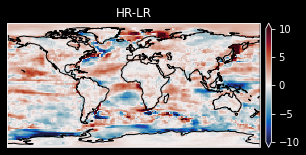

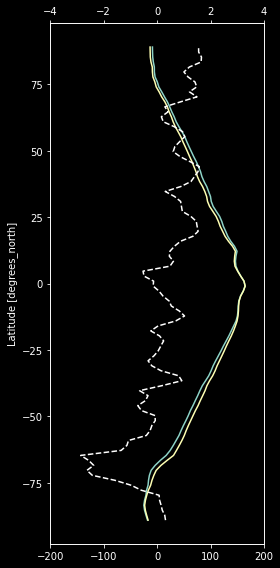

In [22]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,4),
                         subplot_kw={'projection':ccrs.PlateCarree()})

if 1:
    z1 = sfc_1m_all[1]['str'] + sfc_1m_all[1]['ssr']
    z2 = sfc_1m_all[0]['str'] + sfc_1m_all[0]['ssr']
    z = (z1 - z2).groupby('time.month').mean('time').mean('month')
    
    scale = 1./(6*1800)
    vmax = 10
    
    cbar_kwargs = {'label':'', 'pad':0.02}
    (z*scale).plot(ax=ax1, 
                   vmin=-vmax, vmax=vmax,
                   cbar_kwargs=cbar_kwargs,
                   cmap=cmocean.cm.balance,
                   transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_aspect('auto')
    ax1.set_title('HR-LR')
    
fig1.tight_layout()

fig2, ax2 = plt.subplots(1,1,figsize=(4,8))
ax22 = ax2.twiny()
(z1*scale).groupby('time.month').mean('time').mean('month').mean('lon').plot(y='lat',ax=ax2, label='HR')
(z2*scale).groupby('time.month').mean('time').mean('month').mean('lon').plot(y='lat',ax=ax2, label='LR')
((z1-z2)*scale).groupby('time.month').mean('time').mean('month').mean('lon').plot(y='lat',ax=ax22, color='w', linestyle='--')
ax2.set_xlim([-200,200])
ax22.set_xlim([-4,4])
fig2.tight_layout()

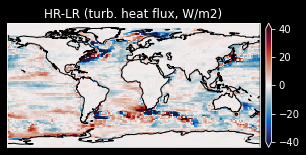

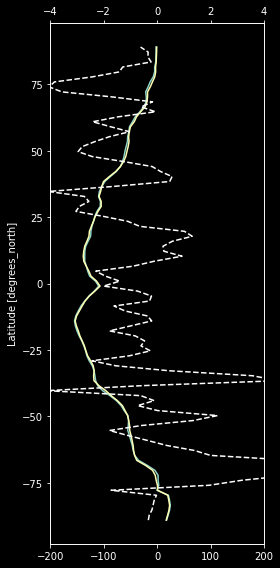

In [23]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,4),
                         subplot_kw={'projection':ccrs.PlateCarree()})

if 1:
    z1 = sfc_1m_all[1]['sshf'] + sfc_1m_all[1]['slhf']
    z2 = sfc_1m_all[0]['sshf'] + sfc_1m_all[0]['slhf']
    z = (z1 - z2).groupby('time.month').mean('time').mean('month')
    
    scale = 1./(6*1800)
    vmax = 40
    
    cbar_kwargs = {'label':'', 'pad':0.02}
    (z*scale).plot(ax=ax1, 
                   vmin=-vmax, vmax=vmax,
                   cbar_kwargs=cbar_kwargs,
                   cmap=cmocean.cm.balance,
                   rasterized=True,
                   transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_aspect('auto')
    ax1.set_title('HR-LR (turb. heat flux, W/m2)')
    
fig1.tight_layout()
fig1.savefig('figures/thf.pdf',format='pdf',dpi=150)

fig2, ax2 = plt.subplots(1,1,figsize=(4,8))
ax22 = ax2.twiny()
(z1*scale).groupby('time.month').mean('time').mean('month').mean('lon').plot(y='lat',ax=ax2, label='HR')
(z2*scale).groupby('time.month').mean('time').mean('month').mean('lon').plot(y='lat',ax=ax2, label='LR')
((z1-z2)*scale).groupby('time.month').mean('time').mean('month').mean('lon').plot(y='lat',ax=ax22, color='w', linestyle='--')
ax2.set_xlim([-200,200])
ax22.set_xlim([-4,4])
fig2.tight_layout()

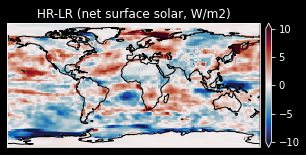

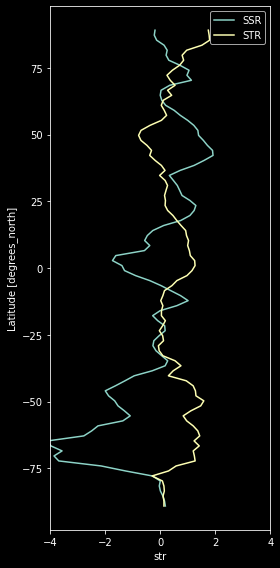

In [28]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,4),
                         subplot_kw={'projection':ccrs.PlateCarree()})

if 1:
    z1 = sfc_1m_all[1]['ssr'] - sfc_1m_all[0]['ssr']
    z2 = sfc_1m_all[1]['str'] - sfc_1m_all[0]['str']
    z = z1.groupby('time.month').mean('time').mean('month')
    
    scale = 1./(6*1800)
    vmax = 10
    
    cbar_kwargs = {'label':'', 'pad':0.02}
    (z*scale).plot(ax=ax1, 
                   vmin=-vmax, vmax=vmax,
                   cbar_kwargs=cbar_kwargs,
                   cmap=cmocean.cm.balance,
                   rasterized=True,
                   transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_aspect('auto')
    ax1.set_title('HR-LR (net surface solar, W/m2)')
    
fig1.tight_layout()
fig1.savefig('figures/ssr.pdf',format='pdf',dpi=150)

fig2, ax2 = plt.subplots(1,1,figsize=(4,8))
(z1*scale).groupby('time.month').mean('time').mean('month').mean('lon').plot(y='lat',ax=ax2, label='SSR')
(z2*scale).groupby('time.month').mean('time').mean('month').mean('lon').plot(y='lat',ax=ax2, label='STR')
ax2.set_xlim([-4,4])
ax2.legend()
fig2.tight_layout()
fig2.savefig('figures/ssr_zm.pdf',format='pdf',dpi=150)

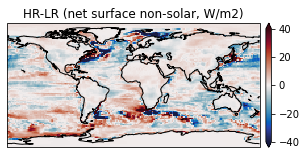

In [80]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,4),
                         subplot_kw={'projection':ccrs.PlateCarree()})

if 1:
    z1 = sfc_1m_all[1]['sshf'] + sfc_1m_all[1]['slhf'] + sfc_1m_all[1]['str']
    z2 = sfc_1m_all[0]['sshf'] + sfc_1m_all[0]['slhf'] + sfc_1m_all[0]['str']
    z = (z1-z2).groupby('time.month').mean('time').mean('month')
    
    scale = 1./(6*1800)
    vmax = 40
    
    cbar_kwargs = {'label':'', 'pad':0.02}
    (z*scale).plot(ax=ax1, 
                   vmin=-vmax, vmax=vmax,
                   cbar_kwargs=cbar_kwargs,
                   cmap=cmocean.cm.balance,
                   rasterized=True,
                   transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_aspect('auto')
    ax1.set_title('HR-LR (net surface non-solar, W/m2)')
    
fig1.tight_layout()
fig1.savefig('figures/qns.pdf',format='pdf',dpi=150)

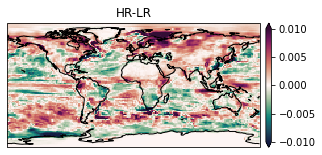

In [59]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,4),
                         subplot_kw={'projection':ccrs.PlateCarree()})

if 1:
    v = 'tclw'
    
    scale = 1
    vmax = 0.01
    z1 = sfc_1m_all[1][v] - sfc_1m_all[0][v]
    z = z1.groupby('time.month').mean('time').mean('month')
    
    cbar_kwargs = {'label':'', 'pad':0.02}
    (z*scale).plot(ax=ax1, 
                   vmin=-vmax, vmax=vmax,
                   cbar_kwargs=cbar_kwargs,
                   cmap=cmocean.cm.curl,
                   transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_aspect('auto')
    ax1.set_title('HR-LR')
    
fig1.tight_layout()

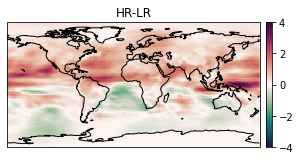

In [66]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,4),
                         subplot_kw={'projection':ccrs.PlateCarree()})

if 1:
    v = 'tcwv'
    
    scale = 1
    vmax = 4
    z1 = sfc_1m_all[1][v] - sfc_1m_all[0][v]
    z = z1.groupby('time.month').mean('time').mean('month')
    
    cbar_kwargs = {'label':'', 'pad':0.02}
    (z*scale).plot(ax=ax1, 
                   vmin=-vmax, vmax=vmax,
                   cbar_kwargs=cbar_kwargs,
                   cmap=cmocean.cm.curl,
                   transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_aspect('auto')
    ax1.set_title('HR-LR')
    
fig1.tight_layout()

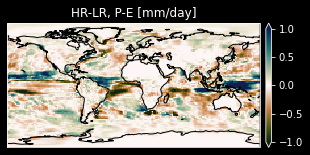

In [11]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,4),
                         subplot_kw={'projection':ccrs.PlateCarree()})

if 1:
    z1 = sfc_1m_all[1]['tp'] + sfc_1m_all[1]['e']
    z2 = sfc_1m_all[0]['tp'] + sfc_1m_all[0]['e']
    z = (z1 - z2).groupby('time.month').mean('time').mean('month')
    
    scale = 8000
    vmax = 1
    
    cbar_kwargs = {'label':'', 'pad':0.02}
    (z*scale).plot(ax=ax1, 
                   vmin=-vmax, vmax=vmax,
                   cbar_kwargs=cbar_kwargs,
                   cmap=cmocean.cm.tarn,
                   rasterized=True,
                   transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_aspect('auto')
    ax1.set_title('HR-LR, P-E [mm/day]')
    
fig1.tight_layout()
fig1.savefig('figures/pe_diff.pdf',format='pdf',dpi=150)

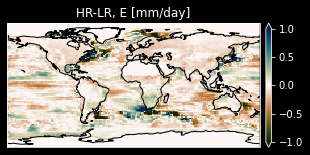

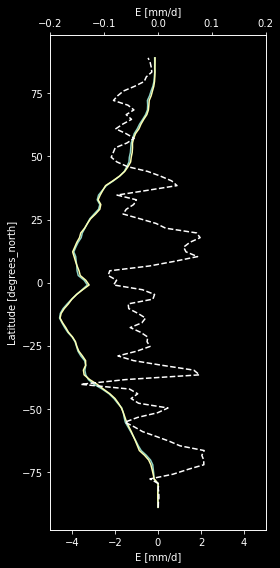

In [36]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,4),
                         subplot_kw={'projection':ccrs.PlateCarree()})

if 1:
    z1 = sfc_1m_all[1]['e'].groupby('time.month').mean('time').mean('month')
    z2 = sfc_1m_all[0]['e'].groupby('time.month').mean('time').mean('month')
    z = (z1 - z2)
    
    scale = 8000
    vmax = 1
    
    cbar_kwargs = {'label':'', 'pad':0.02}
    (z*scale).plot(ax=ax1, 
                   vmin=-vmax, vmax=vmax,
                   cbar_kwargs=cbar_kwargs,
                   cmap=cmocean.cm.tarn,
                   rasterized=True,
                   transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_aspect('auto')
    ax1.set_title('HR-LR, E [mm/day]')
    
fig1.tight_layout()
fig1.savefig('figures/e_diff.pdf',format='pdf',dpi=150)

fig2, ax2 = plt.subplots(1,1,figsize=(4,8))
ax22 = ax2.twiny()
(z1*scale).mean('lon').plot(y='lat',ax=ax2, label='HR')
(z2*scale).mean('lon').plot(y='lat',ax=ax2, label='LR')
(z*scale).mean('lon').plot(y='lat',ax=ax22, color='w', linestyle='--')
ax2.set_xlim([-5,5])
ax22.set_xlim([-0.2,0.2])
ax2.set_xlabel('E [mm/d]')
ax22.set_xlabel('E [mm/d]')
fig2.tight_layout()
fig2.savefig('figures/e_diff_zm.pdf',format='pdf')

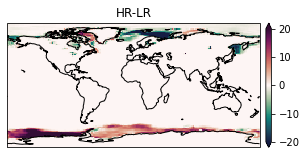

In [62]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,4),
                         subplot_kw={'projection':ccrs.PlateCarree()})

if 1:
    v = 'ci'
    
    scale = 100
    vmax = 20
    z1 = sfc_1m_all[1][v] - sfc_1m_all[0][v]
    z = z1.groupby('time.month').mean('time').mean('month')
    
    cbar_kwargs = {'label':'', 'pad':0.02}
    (z*scale).plot(ax=ax1, 
                   vmin=-vmax, vmax=vmax,
                   cbar_kwargs=cbar_kwargs,
                   cmap=cmocean.cm.curl,
                   transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.set_aspect('auto')
    ax1.set_title('HR-LR')
    
fig1.tight_layout()
fig1.savefig('figures/ci_diff.pdf',format='pdf',dpi=150)